In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cpu


1. Feature Extraction

2. anchor 생성

3. RPN network -> 객체의 위치, objectness score 예측

4. 3의 결과 중 상위 N개만

5. 4의 결과를 Fast R CNN에 통과 시켜 location, cls prediction 수행

## Input

(1333, 2000, 3)


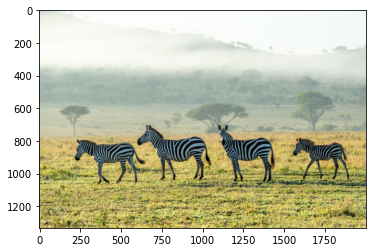

In [4]:
img0 = cv2.imread("/content/zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [5]:
# object information : a set of bounding boxes [x1, y1, x2, y2] (좌상단, 우하단)
# labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

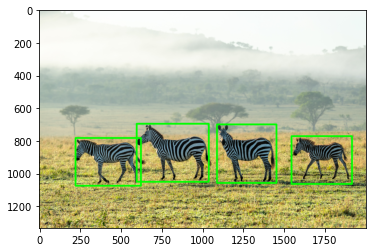

In [6]:
# Ground truth bbox
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

## Preprocessing

VGG16의 입력 형식에 맞게 (800, 800, 3)으로 resize

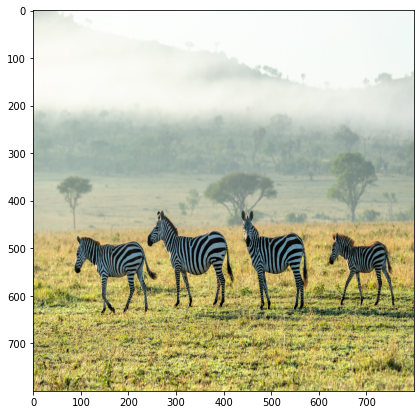

In [7]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


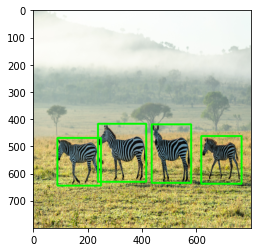

In [8]:
# Bounding box 좌표 수정
Wratio = 800 / img0.shape[1]
Hratio = 800 / img0.shape[0]

# scaling 비율
print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)

# resize된 이미지에 맞게 변환된 bbox 좌표
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 250, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

## 1. Feature Extraction

* 원본 이미지에 VGG 16 네트워크를 적용하여 feature extraction 수행

  - 800 x800으로 resize된 입력 이미지를 입력으로 받아 feature map 출력
  - (B, 3, 800, 800) -> (B, 512, 50, 50)

* 전체 모델에서 subsampling ratio에 맞게 50x50크기가 되는 layer까지만 feature extractor로 사용

<br/>

![image](https://user-images.githubusercontent.com/44194558/146866364-2e772b1a-2423-4d96-bb8b-c231ad6835b0.png)

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
print(len(features))
features  # 모든 layer보기

31


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [11]:
# 필요한 layer만 추출 (50 x 50 이상인 feature map만)
dummy_img = torch.zeros((1, 3, 800, 800)).float()

req_features = []
output = dummy_img.clone().to(DEVICE)

# VGG16 layer들의 output shape를 고려하여 추출
for feature in features:
    # feature extraction per layers
    output = feature(output)
    # print(output.size()) 
    if output.size()[2] < 800 // 16:  # (B, C, H, W)
        break
    req_features.append(feature)
    out_channels = output.size()[1]  # 최종 layer output의 채널

In [12]:
print(len(req_features))
# print(req_features)
print(out_channels)  # 최종 layer의 출력 featue map은 (50 x 50 x 512)

30
512


In [13]:
# Faster R CNN에 사용되는 feature extractor 정의
# layer들을 seuquential 모듈로 변환
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [14]:
faster_rcnn_feature_extractor 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [15]:
# 확인용 - 실제로 최종 출력이 (50x50x512 인지)
transform = transforms.Compose([transforms.ToTensor()])
# 입력 텐서
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


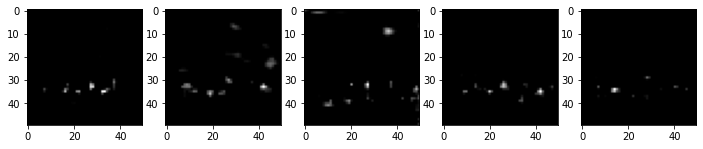

In [16]:
# visualize the first 5 channels of the 50*50*512 feature maps
imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1

## 2. Generate Anchor Box layers

Anchor box : object의 유무에 대한 후보 box

feature map의 모든 위치에 대하여 anchor 생성
 - feature map의 모든 픽셀 위치에 대해 9개의 anchor box 생성
 - 모든 anchor에 대해 label, 객체의 위치를 assign

![image](https://user-images.githubusercontent.com/44194558/146499887-97916930-b8f4-42c0-a52f-4f755fa33ce3.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/146499773-06f5723c-0aa9-48ca-8651-12db1f8d44bb.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/146496640-a599d70f-a392-480a-98db-f9f6383b5c0a.png)

### 2.1 Generate Anchors

In [17]:
feature_size = 800 // 16  # 16 - subsampling ratio (가로, 세로 50개)
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [18]:
# 50x50개 anchor의 좌표 (그리드에 대한 anchor box들의 중심 좌표) 
index = 0
ctr = np.zeros((2500, 2))
for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        # index 번째 anchor의 x, y 중심 좌표 설정
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

In [19]:
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


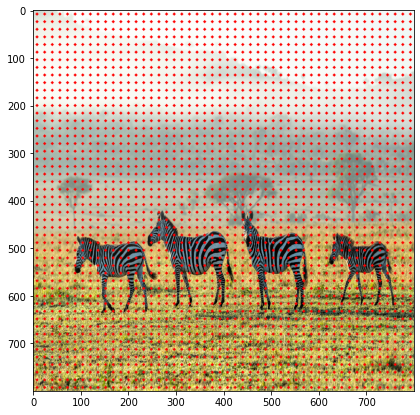

In [20]:
# visualize anchors
img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
               radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

### 2.2 Generate Anchor Boxes

![image](https://user-images.githubusercontent.com/44194558/146866967-782a8fbb-2eee-41ba-b740-417d67a7fabd.png)

In [21]:
# Anchor box 생성
# 2500개의 anchor에 대해 각각 9개의 anchor box 생성 (multi scale, multi aspect ratio)
scales = [8, 16, 32]
ratios = [0.5, 1, 2]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))  # 50x50x9(22500), bbox 좌표 4개
index = 0

# 하나의 anchor마다 서로 다른 ratio, scale을 갖는 anchor box 생성 
for c in ctr:  # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):  # per ratios
        for j in range(len(scales)):  # per scales
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1/ratios[i])

            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1

print(anchor_boxes.shape)  # 2500 x 9
# x1, y1, x2, y2
# 음수는 anchor box가 이미지 외부에 걸쳐져 있다는 뜻
print(anchor_boxes[:10, :])             

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


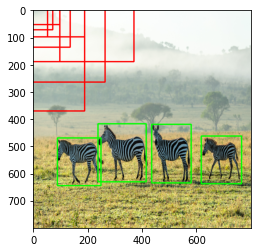

In [22]:
img_clone = np.copy(img)

# 하나의 anchor에 대한 9개의 anchor box 시각화
for i in range(0, 9):  # for i in range(11025, 11034)
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),  # red
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)  # green

plt.imshow(img_clone)
plt.show()

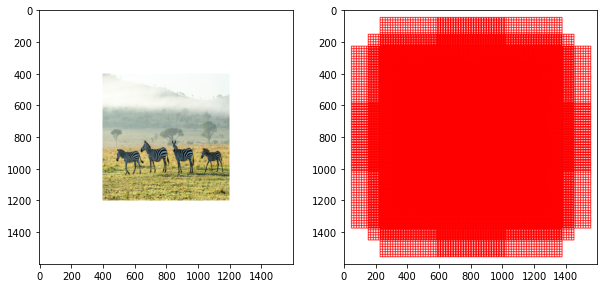

In [23]:
# 모든 anchor box 시각화
# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3, 400, 400, 400, 400, cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                  thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

`Assign the labels and location of objects (with respect to the anchor) to each and every anchor.`

Note that single ground-truth object may assign positive labels to multiple anchors.

이미지에 존재하는 객체들을 해당 객체를 포함하는 anchor box들에 할당

Positive label 할당
 - ground truth box와 가장 높은 iou값을 갖는 anchor
 - ground truth box와 iou값이 0.7 이상

Negative label 할당
 - ground truth box와 iou값이 0.3 이하

Positive도 negative도 아닌 anchor들은 학습에 영향을 끼치지 않음


### 2.3 Generate Target Anchor layers

RPN을 학습시키기 위해 적절한 anchor box를 선택

22500개의 anchor box중 이미지 내부에 있는 8940개의 box들만 추출

In [24]:
anchor_boxes.shape

(22500, 4)

In [25]:
# 800 x 800 이미지의 내부에 있는 box들만
# (x, y) 좌표 값이 각각 0~800사이
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)  # 22500개의 anchor box 중 8940개가 유효

(8940,)
(8940, 4)


### 2.4 Calculate IOUs

8940개의 anchor box, 4개의 예측 가능한 object (얼룩말 4마리)

개별 anchor box마다 4개의 모든 object(ground truth bbox)에 대한 iou 계산

In [26]:
ious = np.empty((len(valid_anchor_boxes), 4), dtype=np.float32)
ious.fill(0)

# target anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box  # 좌상단, 우하단
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        # intersection area btw target & gt
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        # iou
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0  # gt box와 겹치는 영역 없음
        
        # i번째 anchor box에 대해 j번째 객체의 gt box와의 iou 저장
        ious[i, j] = iou

In [27]:
print(ious.shape)
print(ious[2500:2510, :])
print()
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.01566913 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.02893781 0.06473755 0.03603091 0.        ]
 [0.         0.         0.         0.        ]]

[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


### 2.5 Assign positive/negative labels to anchor boxes

![image](https://user-images.githubusercontent.com/44194558/146503211-ee237a97-a12f-462c-b8c5-f5310cde2cba.png)

In [28]:
ious

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.11051063],
       [0.        , 0.        , 0.        , 0.08043041],
       [0.        , 0.        , 0.        , 0.05193678]], dtype=float32)

`argmax_ious` — Tells which ground truth object has max iou with each anchor.

`max_ious` — Tells the max_iou with ground truth object with each anchor.

`gt_argmax_ious` — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

#### 2.5.1 The highest iou for each gt_box and its corresponding anchor box

What anchor box has max ou with the ground truth box

In [29]:
# 4개의 object 각각에 대해 iou가 가장 높은 anchor box의 인덱스 추출
gt_argmax_ious = ious.argmax(axis=0)  # 각 열을 따라 가장 높은 값의 인덱스 제공
print(gt_argmax_ious)

# 각 object에 대한 최대 iou값들
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]


#### 2.5.2 The highest iou for each anchor box and its corresponding ground truth box

What ground truth bbox is associated with each anchor box

In [30]:
# 8940개의 valid anchor box에 대해 어떤 객체의 gt box와 iou가 가장 큰지
argmax_ious = ious.argmax(axis=1)  # 각 행을 따라 가장 높은 값의 인덱스 제공
print(argmax_ious.shape)
print(argmax_ious)

# 8940개의 valid anchor box에 대해 iou 최댓값 추출
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious.shape)
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
(8940,)
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [31]:
print(ious)
print(ious.argmax(axis=1))

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]
[0 0 0 ... 3 3 3]


In [32]:
# 최대의 iou값을 갖는 anchor box의 index들 (중복되는 경우 포함)
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [33]:
print(np.where(ious == gt_max_ious))
print(ious[1008])
print(ious[8707])

(array([1008, 1013, 1018, 1226, 1232, 1238, 2862, 2869, 2876, 3108, 3115,
       3122, 3336, 3343, 3350, 3354, 3357, 3361, 3364, 3368, 3371, 3377,
       3383, 3389, 3600, 3607, 3614, 3846, 3853, 3860, 5935, 5942, 6164,
       6171, 6178, 6181, 6185, 6188, 6192, 6198, 6427, 6434, 8699, 8703,
       8707]), array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3]))
[0.58514285 0.         0.         0.        ]
[0.        0.        0.        0.6325869]


### 2.6 Sample positive/negative anchor boxes for training RPN

In [34]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [35]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

# 4개 객체의 ground truth box에 대해 최대의 iou 값을 갖는 valid anchor box들에 1 할당
label[gt_argmax_ious] = 1

# anchor box 별로 iou 최댓값을 기준으로 label 할당
label[max_ious >= pos_iou_threshold] = 1  # object
label[max_ious < neg_iou_threshold] = 0  # background



하나의 이미지 당 256개의 anchor 추출 (pos/neg 비율을 1:1로 맞춰서)

`Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones.`

In [36]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample  # # of positive samples 

pos_index = np.where(label == 1)[0]

# positive label이 over sampling되면
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                     size = (len(pos_index) - n_pos),
                                     replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)  # # of negative samples
neg_index = np.where(label == 0)[0]

# negativbe label이 over sampling되면
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                     size = (len(neg_index) - n_neg), 
                                     replace = False)
    label[disable_index] = -1

### 2.7 Assigning locations to anchor boxes

Assign the locations to each anchor box with the ground truth object which has maximum iou

In [37]:
bbox  # ground truth

array([[ 89, 469, 249, 644],
       [238, 417, 415, 630],
       [435, 419, 580, 634],
       [617, 462, 765, 637]])

In [38]:
# Tells which ground truth object has max iou with each anchor.
argmax_ious

array([0, 0, 0, ..., 3, 3, 3])

In [39]:
# For each anchor box, find the groundtruth object which has max_iou
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

(8940, 4)


In [40]:
max_iou_bbox

array([[ 89, 469, 249, 644],
       [ 89, 469, 249, 644],
       [ 89, 469, 249, 644],
       ...,
       [617, 462, 765, 637],
       [617, 462, 765, 637],
       [617, 462, 765, 637]])

Find the locations of ground truth with respect to the anchor box location

![image](https://user-images.githubusercontent.com/44194558/146872572-b1da4998-8641-4e0f-886b-20b2a45c0f17.png)

In [41]:
# convert the format of valid anchor boxes [x1, y1, x2, y2] -> [x, y, w, h]
# 모든 valid anchor box에 대해 최대의 iou를 갖는 ground truth object의 bbox
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# convert format
height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [42]:
# 초기화 : 22500개의 anchor box에 대해 label=-1, locations=0 
# 8940개의 valid anchor box에 대해 location, label 설정
# 학습 시 매 epoch마다 8940개의 valid anchor box 중 256(128/128)개의 box를 랜덤하게 샘플링 (나머지는 -1)
# Final anchor labels
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

# Final anchor locations
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [43]:
anchor_locs

array([[14.22800271,  2.49973296,  2.70071784, -0.03381788],
       [14.22800271,  2.41134461,  2.70071784, -0.03381788],
       [14.22800271,  2.32295626,  2.70071784, -0.03381788],
       ...,
       [-0.51108439, -0.63252911, -1.55207383, -0.03381788],
       [-0.51108439, -0.72091746, -1.55207383, -0.03381788],
       [-0.51108439, -0.80930581, -1.55207383, -0.03381788]])

## 3. RPN

VGG16으로부터 feature map을 입력받아 anchor에 대한 class score, bounding bos regressor를 반환

- Input : 50x50x512 sized feature map

- Process : Region proposal by RPN

- Output : class scores(50x50x2x9 sized feature map) and bounding box regressors(50x50x4x9 sized feature map)

class score, bounding bos regressor는 proposal layer의 입력으로 제공되어 최적의 region proposals를 추출 

![image](https://user-images.githubusercontent.com/44194558/146873947-c046e881-7be6-4c83-8cc2-28e8eac33ee0.png)


<br/>

![image](https://user-images.githubusercontent.com/44194558/146516653-0fa53022-d85d-4293-bc4c-45c8993acd1b.png)

To generate region proposals, we slide a small network over the convolutional feature map output that we obtained in the feature extraction module. 

<br/>

![image](https://user-images.githubusercontent.com/44194558/146899413-d16aa1a0-df8a-4c93-bebc-a8385c7831d4.png)
 
 - 좌 : anchor box 종류에 따라 객체 포함 여부를 나타내는 feature map
 - 우 : anchor box 종류에 따라 bbox regressor를 나타내는 feature map




### 3.1 Define RPN

In [44]:
in_channels = 512  # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### 3.2 Classification & Bounding box regression

In [45]:
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output(objectness score) 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [46]:
# Convert format for prediction
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [47]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


### 3.3 Multi-task loss

![image](https://user-images.githubusercontent.com/44194558/146874786-ad69eca5-d13c-4fb9-8927-75566f1ccd5a.png)

#### 3.3.1 classification loss

In [48]:
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6848, grad_fn=<NllLossBackward0>)


#### 3.3.2 RPN loss

According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, calculate the RPN loss¶

positive sample에 대해서만 계산

In [49]:
# mask : positive/negative 여부 저장 (positive sample만)
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

# smooth L1 loss
x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(17.4786, dtype=torch.float64, grad_fn=<SumBackward0>)


#### 3.3.3 Total loss

In [50]:
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.5690, dtype=torch.float64, grad_fn=<AddBackward0>)


## 4. Region Proposal by Proposal Layer

Anchor generation layer에서 생성된 anchor boxes와 RPN에서 반환한 class scores, bounding box regressor를 사용하여 region proposals를 추출

score 변수에 저장된 objectness score를 내림차순으로 정렬한 후 objectness score 상위 N(n_train_pre_nms=12000)개의 anchor box에 대하여 Non maximum suppression 알고리즘을 수행

<br/>

`Input` : 22500(=50x50x9) anchor boxes, class scores(50x50x2x9 sized feature map) and bounding box regressors(50x50x4x9 sized feature map)

`Process` : region proposal by proposal layer

`Output` : top-N ranked region proposals

#### 4.1 Transfrom anchor boxes

In [51]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [52]:
# the labelled 22500 anchor boxes
# convert format : [x1, y1, x2, y2] -> [ctr_x, ctr_y, w, h]
anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [53]:
# convert the pred_anchor_locs and objectness_score to numpy array
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [54]:
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [55]:
# convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2] format
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


### 4.2 Clip the anchor boxes to the image

In [56]:
# clip the predcited boxes to the image
img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [57]:
hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


### 4.3 Select top-12000 anchor boxes by objectness score

In [58]:
order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [59]:
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


### 4.4 NMS - select 2000 bounding boxes

In [60]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# calculate the areas of all the boxes
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [61]:
order = order.argsort()[::-1]
keep = []

while (order.size > 0):
    i = order[0] # take the 1st elt in roder and append to keep
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]  # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


최종 region proposal -> Fast R CNN의 입력으로 사용

## 5. Proposal Target Layer

Proposal layer의 출력인 region proposals 중 Fast R CNN을 학습시키기 위한 sample을 선택

 - 이 과정에서 샘플링된 region proposals는 과정 1의 출력 feature map에 대해 ROI pooling 수행


Region proposals, ground truth box의 iou를 계산하여 pos/neg 분류

In [62]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

### 5.1 Calculate iou

region proposals와 ground truth의 iou 계산

In [63]:
ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)

    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [64]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 3 0 ... 0 0 0]
[0.39423883 0.03022641 0.         ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


### 5.2 Select positive & negative samples

In [65]:
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

12
[1134 1175  121   14  154 1078 1224   16 1627  424  970  155]


In [66]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

116
[1333 1107  132   74  528 1925  391  464  113  117  446 1051 1113  418
 1946 1733  954 1833 1363 1075  550  518  621  641 1900  747 1711 1754
   29 1710 1315  575 1504 1931 1038  402  856  137 1357  428  522  308
  318  311 1555 1834 1028 1292 1071 1957 1718 1613  670 1411  652  396
  614  292 1927  251 1817 1218 1936 1178   71 1207 1299 1999  733  624
  278 1308  447 1569  582  931  795 1120 1080 1126  350 1400  990 1413
 1596 1252 1154  596 1784 1617 1171  173  983   98  404  372 1069 1708
 1695  229 1266 1011  815  814 1034 1242  351  619 1516  268  302  841
 1305  888 1926 1714]


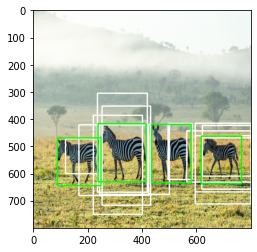

In [67]:
# display roi samples with positive
img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

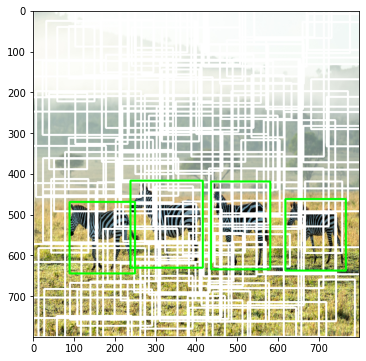

In [68]:
# display roi samples with negative
img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

### 5.3 Gather positive/negative samples

In [69]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [70]:
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [71]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [72]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## 6. ROI pooling

Feature extraction을 통해 얻은 feature map, proposal target layer에서 추출한 region proposals를 활용하여 ROI pooling 수행

Feature map 상의 임의의 roi를 고정 크기의 pooling 영역으로 mapping
 - 출력 feature map은 7x7 크기가 되도록



![image](https://user-images.githubusercontent.com/44194558/146897839-1c9d9f6a-8d8f-4a83-aa9b-0822e7631fdf.png)

### 6.1 Concatenate labels with bbox coordinates

In [73]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [74]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


### 6.2 ROI pooling

In [75]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())  # 7x7 사이즈로 고정

torch.Size([128, 512, 7, 7])


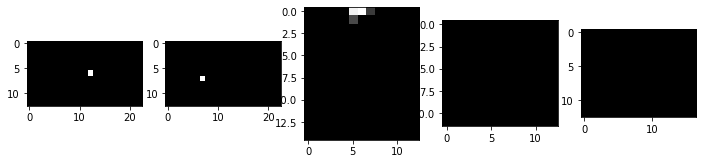

In [76]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [77]:
# feed forward layer의 입력으로 사용될 수 있도록 reshape
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7x7x512

torch.Size([128, 25088])


## 7. Fast R CNN


![image](https://user-images.githubusercontent.com/44194558/146897485-2d761626-1041-4443-a62e-5db09137844e.png)

In [78]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 1 class, 1 background

In [79]:
k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [80]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [82]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


In [84]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [87]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [88]:
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [89]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([12, 4]) torch.Size([12, 4])
tensor(3.0129, dtype=torch.float64, grad_fn=<SumBackward0>)


In [90]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.8035, 1.9042, 0.9682, 1.2000],
        [0.8803, 0.9098, 0.7778, 1.6240],
        [0.7217, 2.2409, 1.7295, 1.8729],
        [1.0617, 1.1486, 0.9083, 0.8113],
        [0.8791, 0.7280, 1.1046, 1.4465],
        [0.7951, 1.8352, 0.7281, 0.8280],
        [0.7241, 1.0666, 0.7234, 0.7482],
        [0.7462, 2.5457, 1.7797, 1.0726],
        [2.7724, 1.4282, 1.1731, 2.7740],
        [1.9200, 1.1613, 2.4660, 1.2426],
        [0.9461, 1.0043, 3.6491, 0.7686],
        [0.7679, 2.5586, 2.0381, 0.7311]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([[5.3725, 6.4732, 5.5372, 5.7690],
        [5.4493, 5.4788, 5.3468, 6.1930],
        [5.2907, 6.8099, 6.2985, 6.4419],
        [5.6307, 5.7176, 5.4773, 5.3803],
        [5.4481, 5.2970, 5.6736, 6.0155],
        [5.3641, 6.4042, 5.2971, 5.3970],
        [5.2931, 5.6356, 5.2924, 5.3172],
        [5.3152, 7.1147, 6.3486, 5.6416],
        [7.3414, 5.9972, 5.7421, 7.3430],
        [6.4890, 5.7303, 7.0350, 5.8116],
        [5.5151, 5.5733